In [433]:
# Set global font properties for better readability
sns.set_style("ticks")

plt.rcParams["font.family"] = "sans-serif"  # Use a sans-serif font
plt.rcParams["font.sans-serif"] = [
    "DejaVu Sans",
    "Liberation Sans",
    "Helvetica",
    "Arial",
]
plt.rcParams["font.size"] = 12  # Default font size
plt.rcParams["axes.facecolor"] = "#e7e7e7"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
# Make
#    ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
plt.rcParams["axes.labelpad"] = 10  # Padding between axes label and ticks

plt.rcParams.update(
    {
        "text.usetex": False,
        "text.latex.preamble": r"\usepackage{amsmath}",
    }
)
# Larger font sizes for specific elements
TITLE_FONT_SIZE = 14
plt.rcParams["axes.titlesize"] = TITLE_FONT_SIZE
plt.rcParams["figure.titlesize"] = TITLE_FONT_SIZE
LABEL_FONT_SIZE = 13
plt.rcParams["axes.labelsize"] = LABEL_FONT_SIZE
TICK_LABEL_SIZE = 12
plt.rcParams["xtick.labelsize"] = TICK_LABEL_SIZE
LEGEND_FONT_SIZE = 12
plt.rcParams["legend.fontsize"] = LEGEND_FONT_SIZE
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file = "measurements_bits_block2_4_8_16.csv"
df = pd.read_csv(file)

df = (
    df.groupby(
        ["compiler_version", "compiler_flags", "cpu_model", "implementation", "bits"]
    )
    .median()
    .reset_index()
)
df["ops"] = df["bits"] * 3 ** df["bits"]
df["memory"] = (3 ** df["bits"]) / 8
df["operational_intensity"] = df["ops"] / df["memory"]
df["performance"] = df["ops"] / df["cycles"]
df["function"] = (
    df["implementation"] + ", " + df["compiler_version"] + ", " + df["compiler_flags"]
)
print(df)

colors = [
    "#b9002e",
    "#005cb9",
    "#5cb900",
    "#b95c00",
    "#820082",
    "#00b9b9",
    "#b9b900",
    "#8a2e8a",
    "#009e9e",
    "#aa7f2a",
    "#2a2aaa",
    "#9e6900",
]


# Generate an unique color for each function x cpu_model combination
unique_functions = df["function"].unique()
unique_cpu_models = df["cpu_model"].unique()
# colors = sns.color_palette("pastel6", len(unique_functions) * len(unique_cpu_models))
color_map = {}
for i, function in enumerate(unique_functions):
    for j, cpu_model in enumerate(unique_cpu_models):
        color_map[(cpu_model, function)] = colors[i * len(unique_cpu_models) + j]

                compiler_version        compiler_flags  \
0   gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
1   gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
2   gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
3   gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
4   gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
..                           ...                   ...   
83  gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
84  gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
85  gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
86  gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   
87  gcc (Debian 14.2.0-8) 14.2.0  -march=native -Ofast   

                               cpu_model        implementation  bits  \
0   12th Gen Intel(R) Core(TM) i7-12700H  bits_sp_load_block16     1   
1   12th Gen Intel(R) Core(TM) i7-12700H  bits_sp_load_block16     2   
2   12th Gen Intel(R) Core(TM) i7-12700H  bits_sp_load_block16     3   
3   12th Gen In

In [434]:
import networkx as nx
from matplotlib.lines import Line2D
from typing import List, Tuple


def plot_networkx_spring_labels(
    lines: List[Line2D], k: float = 0.6, *, indicies: List[int]
):
    """
    Plots lines and dynamically labels them on the chart using networkx's spring layout.

    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        data_lines (list of tuples): Each tuple should be (x_data, y_data).
        labels (list of str): Corresponding labels for each line.
    """
    G = nx.Graph()
    initial_pos = {}  # Store initial positions for fixed anchor points
    num_lines = len(lines)
    for i, line in enumerate(lines):
        x, y = line.get_xdata(), line.get_ydata()
        for j in indicies:
            anchor_x = x[j]
            anchor_y = y[j]
            anchor_node_name = f"anchor_{i}_{j}"
            label_node_name = f"label_{i}_{j}"

            # Add nodes to the networkx graph
            G.add_node(anchor_node_name)
            G.add_node(label_node_name)
            G.add_edge(label_node_name, anchor_node_name)

            # # Connect last 10 points of the line to the label node
            # last = anchor_node_name
            # AROUND_N = 1
            # for j, (xi, yi) in enumerate(
            #     zip(x[j - AROUND_N : j + AROUND_N], y[j - AROUND_N : j + AROUND_N])
            # ):
            #     name = f"point_{i}_{j}"
            #     G.add_node(name)
            #     G.add_edge(name, last)
            #     initial_pos[name] = np.array([xi, yi])
            #     last = name

            initial_pos[anchor_node_name] = np.array([anchor_x, anchor_y])

    # --- Run networkx spring layout ---
    # `pos` will be a dictionary mapping node names to (x,y) coordinates
    # We pass `initial_pos` to `pos` to tell spring_layout where our anchor points are fixed.
    # iterations: more iterations for more stability
    # k: optimal distance between nodes. Adjust this to control how close labels are.
    #    Smaller k means labels will be closer, larger k means they'll spread out.
    pos = nx.spring_layout(
        G,
        pos=initial_pos,
        fixed=list(initial_pos.keys()),
        iterations=200,
        k=k,
    )  # Adjust k as needed

    ret = {}
    for i in range(num_lines):
        for j in indicies:
            label_node_name = f"label_{i}_{j}"
            text_x, text_y = pos[label_node_name]
            if i not in ret:
                ret[i] = {}
            ret[i][j] = (text_x, text_y)
    return ret

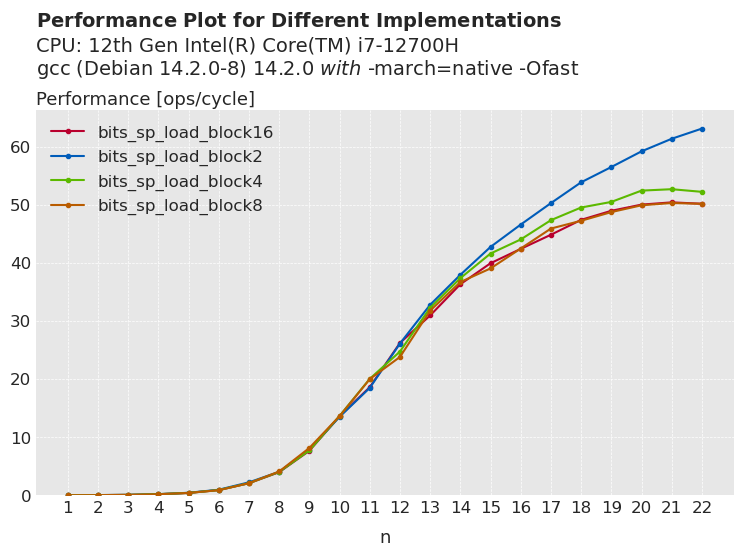

In [435]:
def performance_plot(df: pd.DataFrame):
    for (cpu_model, compiler_version, compiler_flags), df_grouped in df.groupby(
        ["cpu_model", "compiler_version", "compiler_flags"]
    ):
        plt.figure(figsize=(9, 5))
        ax = plt.gca()
        lines: List[Tuple[str, Line2D]] = []
        for function, group in df_grouped.groupby("function"):
            color = color_map[(cpu_model, function)]
            fn_short = function.split(", " + compiler_version)[0]
            group.plot.line(
                x="bits",
                y="performance",
                label=fn_short,
                legend=None,
                marker="o",
                markersize=3,
                linestyle="-",
                color=color,
                ax=ax,
            )
            line = ax.lines[-1]  # Get the last line added to the axes
            lines.append((fn_short, line))

        # Get positions for labels using networkx spring layout
        # positions = plot_networkx_spring_labels([line for _, line in lines], k=1.7)
        # # Add labels at the calculated positions
        # for (function, line), (text_x, text_y) in zip(lines, positions):
        #     ax.text(
        #         text_x,
        #         text_y,
        #         function,
        #         fontsize=LABEL_FONT_SIZE * 0.9,
        #         color=line.get_color(),
        #         ha="left",
        #         va="bottom",
        #         # bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'),
        #     )

        # Keep only bottom spine
        for spine in ("left", "top", "right"):
            ax.spines[spine].set_visible(False)
        plt.legend(
            loc="upper left",
            # bbox_to_anchor=(1, 1),
        )
        plt.xlabel("n")
        plt.ylabel(
            r"Performance [ops/cycle]",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
        nice_title = "Performance Plot for Different Implementations"
        plt.title(
            r"$\mathbf{"
            + nice_title.replace(" ", r" \ ")
            + "}$"
            + f"\nCPU: {cpu_model}\n"
            + f"{compiler_version} "
            + r"$\mathit{with}$ "
            + f"{compiler_flags}",
            loc="left",
            y=1.07,
            # fontdict={"weight": "bold"},
        )
        plt.grid(True)
        plt.autoscale(enable=True, axis="y", tight=False)
        plt.ylim(bottom=0)
        plt.xticks(df_grouped["bits"].unique())
        # plt.savefig("performance.png", dpi=300, bbox_inches="tight")
        plt.show()


performance_plot(df)

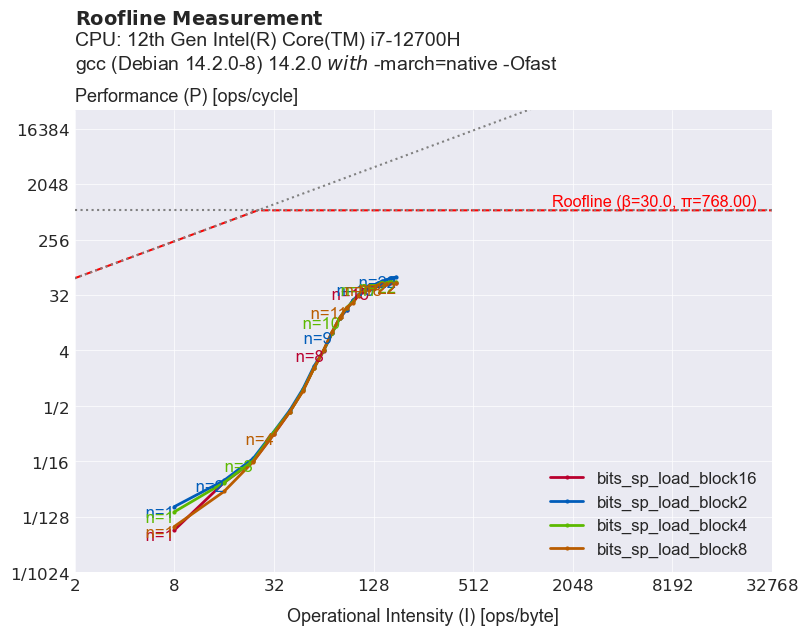

In [444]:
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt


def roofline_plot(df: pd.DataFrame):
    for (cpu_model, compiler_version, compiler_flags), df_grouped in df.groupby(
        ["cpu_model", "compiler_version", "compiler_flags"]
    ):
        # TODO: use hw values here
        PI_PEAK = (
            3 * 256.0
        )  # Skylake: throughput of 3 for _mm256_and_si256 -> 3*356 logic operations per second
        BETA_PEAK = 30.0
        Y_MIN, Y_MAX = 2 ** (-10), 2**15
        X_MIN, X_MAX = 2 ** (1), 2**15
        ABOVE_LINE_TEXT_DELTA = 1.06

        # # IF you wanna see entire memory roofline, uncomment the following lines
        # Calculate X intersection of y = beta*x
        # _x_min = Y_MIN / BETA_PEAK
        # X_MIN = min(X_MIN, _x_min * 0.9)

        LOG_BASE = 2.0

        plt.figure(figsize=(9, 6))
        ax = plt.gca()

        # lines: List[Tuple[int, pd.Series, Line2D]] = []
        for i, (function, df_grouped) in enumerate(df.groupby("function")):
            fn_short = function.split(", " + compiler_version)[0]
            df_grouped.plot.line(
                x="operational_intensity",
                y="performance",
                label=fn_short,
                marker="o",
                legend=None,
                ax=ax,
                color=color_map[cpu_model, function],
                linewidth=2,
                markersize=2,
            )
            # line = ax.lines[-1]  # Get the last line added to the axes
            # lines.append((i, df_grouped.bits, line))

            
            all_rows = list(df_grouped.itertuples())
            # Create a set of some rows, so it's not too crowded
            presentable_rows = set()
            presentable_rows.add(all_rows[0])  # Always include the first row
            presentable_rows.add(all_rows[-1])  # Always include the last row
            # Add some rows in between, but not too many
            step = max(1, len(all_rows) // 3)  # Adjust step to avoid too many points
            presentable_rows = presentable_rows.union(
                all_rows[i::step]
            )  # Add every nth row

            for row in presentable_rows:
                plt.text(
                    row.operational_intensity,
                    row.performance * ABOVE_LINE_TEXT_DELTA,
                    f" n={row.bits}",
                    fontsize=12,
                    verticalalignment="top",
                    horizontalalignment="right",
                    color=color_map[cpu_model, function],
                    transform=ax.transData,
                )
        # positions = plot_networkx_spring_labels(
        #     [line for _, _, line in lines],
        #     k=1.2,
        #     indicies=[0, -1],
        # )
        # print(positions)
        # # positions[fn_idx][bits_idx]
        # for i, bits, line in lines:
        #     for bit_idx, (text_x, text_y) in positions[i].items():
        #         print(f"Function {i}: {bit_idx}")
        #         ax.text(
        #             text_x,
        #             text_y,
        #             bits.iloc[bit_idx],
        #             fontsize=LABEL_FONT_SIZE * 0.9,
        #             color=line.get_color(),
        #             ha="left",
        #             va="bottom",
        #             # bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'),
        #         )

        # Calculate roofline points
        intensity_range = np.logspace(np.log10(X_MIN), np.log10(X_MAX), 100)

        # Memory-bound roof (Performance = Beta * Intensity)
        memory_roof = BETA_PEAK * intensity_range

        # Compute-bound roof (Performance = Pi_peak)
        compute_roof = np.full_like(intensity_range, PI_PEAK)

        # Actual roofline is the minimum of the two
        roofline = np.minimum(memory_roof, compute_roof)

        plt.plot(
            intensity_range,
            roofline,
            color="red",
            linestyle="--",
            # label=f"Roofline (β={BETA_PEAK:.1f}, π={PI_PEAK:.2f})",
        )
        plt.text(
            X_MAX * 0.8,
            roofline[-1] * 1.05,
            f"Roofline (β={BETA_PEAK:.1f}, π={PI_PEAK:.2f})",
            fontsize=LABEL_FONT_SIZE * 0.9,
            color="red",
            ha="right",
            va="bottom",
        )
        # Optionally plot the components
        plt.plot(
            intensity_range,
            memory_roof,
            color="grey",
            linestyle=":",
            # label="Memory Bound",
        )
        plt.plot(
            intensity_range,
            compute_roof,
            color="grey",
            linestyle=":",
            # label="Compute Bound",
        )

        # --- Formatting ---

        plt.yscale("log", base=2)
        plt.xscale("log", base=2)

        nice_title = "Roofline Measurement"
        plt.title(
            r"$\mathbf{"
            + nice_title.replace(" ", r" \ ")
            + "}$"
            + f"\nCPU: {cpu_model}\n"
            + f"{compiler_version} "
            + r"$\mathit{with}$ "
            + f"{compiler_flags}",
            loc="left",
            y=1.07,
            # fontdict={"weight": "bold"},
        )

        plt.xlabel(
            "Operational Intensity (I) [ops/byte]",
            # fontdict={"weight": "bold"},
        )
        plt.ylabel(
            "Performance (P) [ops/cycle]",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)

        ax = plt.gca()
        for spine in ("left", "right", "top"):
            ax.spines[spine].set_visible(False)

        # Show symbolic fractions for ticks
        def log_ticks(x, pos):
            if x < 1:
                return r"${1}/{%d}$" % (LOG_BASE ** (-(np.log2(x))))
            return r"${%d}$" % (x)

        ax.xaxis.set_major_locator(LogLocator(base=LOG_BASE))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(log_ticks))

        ax.yaxis.set_major_locator(LogLocator(base=LOG_BASE))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(log_ticks))

        ax.yaxis.set_ticks_position("left")

        plt.legend()
        # Background grid should be gray and lines should be white
        plt.grid(True)
        plt.xlim(X_MIN, X_MAX)
        plt.ylim(Y_MIN, Y_MAX)
        plt.savefig("merge_roofline.png", dpi=300, bbox_inches="tight")
        plt.show()


roofline_plot(df)

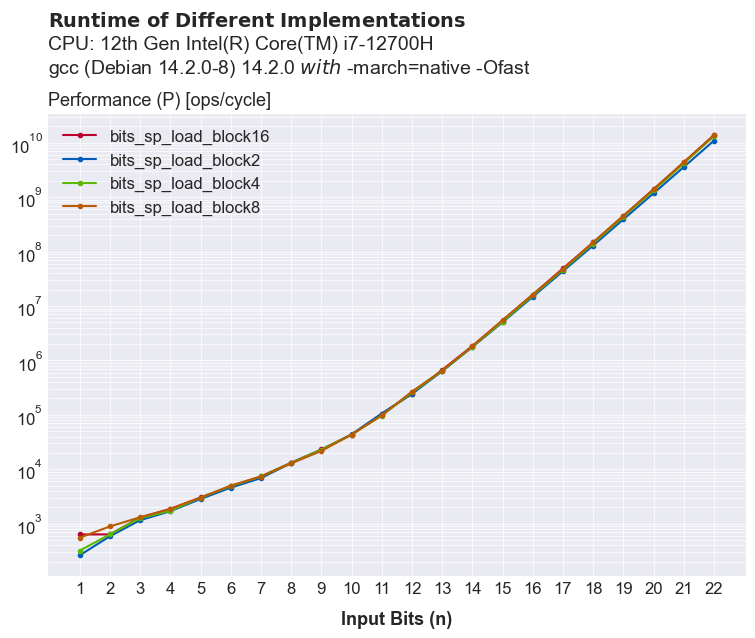

In [442]:
def runtime_plot(df:pd.DataFrame):
    """
    Generates a log-runtime plot for different implementations.
    Creates a separate plot for each CPU model found in the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'bits', 'cycles',
                           'function', and 'cpu_model' columns.
    """
    # Group by CPU model to create a separate plot for each
    for (cpu_model, compiler_version, compiler_flags), df_grouped in df.groupby(
        ["cpu_model", "compiler_version", "compiler_flags"]
    ):
        # Create the plot
        plt.figure(figsize=(9, 6))
        ax = plt.gca()
        for function, group in df_grouped.groupby("function"):
            color = color_map[(cpu_model, function)]
            fn_short = function.split(", " + compiler_version)[0]
            group.plot.line(
                x="bits",
                y="cycles",
                label=fn_short,
                legend=None,
                marker="o",
                markersize=3,
                linestyle="-",
                color=color,
                ax=ax,
            )

        # --- Formatting ---
        # Set y-axis to a logarithmic scale, which is crucial for runtime plots
        plt.yscale("log")

        # Labels and Title
        plt.xlabel(
            "Input Bits (n)",
            fontdict={"weight": "bold"},
        )
        plt.ylabel("Runtime [cycles] (log scale)")
        plt.title(
            f"Runtime of all implementations for different number of bits n\nCPU: {cpu_model}",
            loc="left",
        )

        plt.ylabel(
            "Performance (P) [ops/cycle]",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
        
        nice_title = "Runtime of Different Implementations"
        plt.title(
            r"$\mathbf{"
            + nice_title.replace(" ", r" \ ")
            + "}$"
            + f"\nCPU: {cpu_model}\n"
            + f"{compiler_version} "
            + r"$\mathit{with}$ "
            + f"{compiler_flags}",
            loc="left",
            y=1.07,
            # fontdict={"weight": "bold"},
        )

        # Grid and Ticks for better readability
        plt.grid(True, which="both")
        plt.xticks(df_grouped["bits"].unique())

        # Save and show the plot
        # Create a unique filename for each CPU to avoid overwriting
        safe_cpu_model_name = cpu_model.replace(" ", "_").replace("@", "")
        plt.legend()
        plt.show()


runtime_plot(df)